# Семинар 10: статистика и A/B тестирование

## Вступление
После имплементации любого продуктового решения создателям непременно приходится оценивать его качество по поведению реальных пользователей. Зачастую это делается так: с пользователей собираются анонимные логи (скачивания, клики, статистика использования отдельных фичей продукта). Для многих продуктовых решений невозможно заранее понять, какие детали имплементации вызовут более положительную реакцию пользователей, поэтому имеет место A/B тестирование: разным группам пользователей предоставляются разные решения, и отслеживается разница собранных статистик между всеми группами. Однако не всегда легко понять, насколько случайны наблюдаемые различия между статистиками, собранными с разных групп. Сегодня мы обсудим базовые понятия из статистики и рассмотрим набор методов, который позволит нам с уверенностью рассуждать о наличии или отсутствии различий в разных выборках.

### План семинара
1. Случайные величины
    1. Распределение вероятностей
    2. Функция распределения
2. Нормальный закон распределения
    1. Закон больших чисел и центральная предельная теорема
    2. Формулы для функции и плотности нормального распределения
    3. Генерирование выборки, графики функций распределения и плотностей, эмпирических и теоретических
3. Нахождение доверительных интервалов
    1. Упражнения и теория
    2. Доверительный интервал на основе нормального распределения
    3. Доверительный интервал Уилсона (лучше, для средних значений близких к 0 и 1)
4. Проверка гипотез
    1. Критерии Стьюдента
        1. Одновыборочный критерий Стьюдента
        2. Двувыборочный критерий Стьюдента
        3. Двувыборочный критерий Стьюдента для зависимых выборок
    2. Непараметрические критерии
        1. Двувыборочный непараметрический критерий для независимых выборок
        2. Ранговый критерий Манна-Уитни
5. A/B тестирование

In [1]:
import random
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as sts
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.weightstats import *

warnings.filterwarnings("ignore")
random.seed(42)

%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1. Случайные величины

Случайные величины бывают дискретные и непрерывные. Как можно догадаться из названия, первые принимают значения из дискретного множества (конечного или счётного), вторые — из непрерывного.

На практике статистические заключения опираются на допущения о том, как распределены рассматриваемые случайные переменные (данные). Даже принято преобразовывать данные так, чтобы они соответствовали одному из известных распределений: вспомните, например, `StandardScaler`.

### 1.1 Распределение вероятностей
*Закон распределения вероятностей — это выражение, которое определяет, какие значения будет принимать данная переменная или параметр, и как часто будет встречаться каждое из этих значений.*

Строго говоря, такое определение верно для дискретных случайных величин. С непрерывными всё чуть сложнее, потому что конкретное значение они принимают с вероятностью 0. Вместо этого для них определяют закон распределения через плотность распределения. Впрочем, сейчас для нас это скорее детали.

Иногда закон распределения случайной величины можно выписать сразу. Например, если случайная величина $X$ — число выпадающих очков при бросках игральной кости (шестигранный кубик с точками), то закон распределения её значений можно представить в виде таблицы:

| | | | | | | |
|-------------:|:---------|:--------|:---------|:---------|:--------|:---------|
|$$X$$         |1         |2        |3         |4         |5        |6         |
|$$p(X)$$      |1/6       |1/6      |1/6       |1/6       |1/6      |1/6       |

На практике мы далеко не всегда заранее знаем закон распределения случайной величины (ее функцию вероятности). В таком случае мы стараемся оценить её на основании имеющихся данных.

Проведём эксперимент. Смоделируем на питоне результаты $n=200$ бросков игральной кости.

In [2]:
n = 20000
sample = np.random.choice([1, 2, 3, 4, 5, 6], n)
print("Выпавшие значения Х:", sample)

Выпавшие значения Х: [3 4 2 ... 5 6 1]


Вероятности значений случайной величины $X$ можно оценить с помощью *относительных частот* выпадения значений.

In [3]:
c = Counter()
for i in sample:
    c[i] += 1

print("Число выпадений каждого значения:")
print(c, "\n")

print("Вероятности выпадений каждого значения:")
p_X = {key: value / n for key, value in c.items()}
print(p_X)

Число выпадений каждого значения:
Counter({3: 3420, 2: 3396, 5: 3359, 4: 3337, 6: 3244, 1: 3244}) 

Вероятности выпадений каждого значения:
{3: 0.171, 4: 0.16685, 2: 0.1698, 6: 0.1622, 1: 0.1622, 5: 0.16795}


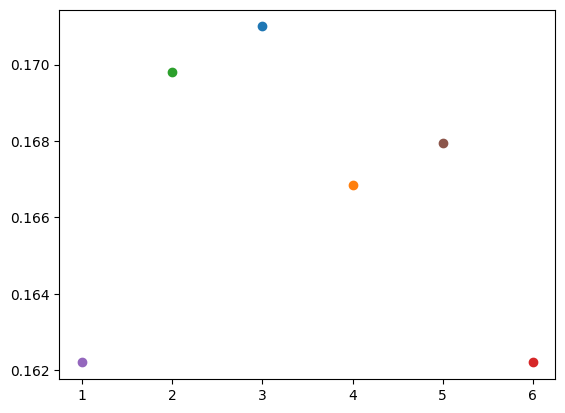

In [4]:
# нарисуем распределение вероятностей:
for key in p_X:
    plt.scatter([key], p_X[key], label=key)
plt.show()

**Задание.** Проведите эксперименты для 2000, 20000, 200000 бросков. Что происходит с вероятностями? Что за значение, к которому вероятности стремятся?

### 1.2 Функция распределения
Знание распределения вероятностей позволяет построить *функцию распределения* $F(x)$. Обратное тоже верно.

$F(x)$ — это вероятность того, что случайная величина $X$ примет значение меньшее или равное, чем $x$, т.е. $F(x)=P(X\leq x).$

Из этого определения следует очень важная для практики формула вероятности попадания случайной величины $X$ в интервал:

$$P(a<X\leq b)=F(b)-F(a).$$

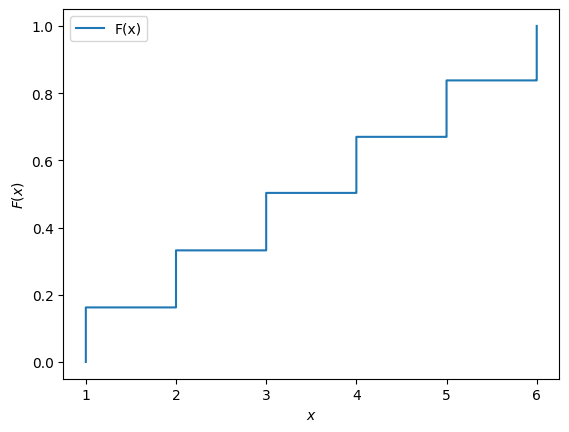

In [5]:
# построим функцию распределения для нашей выборки
F = ECDF(sample, side="right")
plt.step(F.x, F.y, label="F(x)")

plt.ylabel("$F(x)$")
plt.xlabel("$x$")
plt.legend(loc="upper left");

In [6]:
print(F([4]))

[0.66985]


**Задание.**
1. Найдите F(1), F(3), F(6), F(10). Почему получились именно такие значения?

2. Найдите вероятность того, что при броске выпадет не менее 3 и не более 5 очков.

In [7]:
# your code here

print("Задание 1: ")
print(F(1), F(3), F(6), F(10))

print("Задание 2: ")
print(F(5) - F(2))

Задание 1: 
0.1622 0.503 1.0 1.0
Задание 2: 
0.5058


Построим гистаграмму принимаемых значений

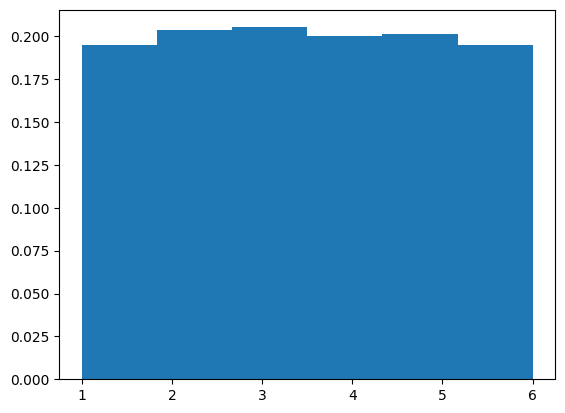

In [8]:
plt.hist(sample, bins=6, density=True);

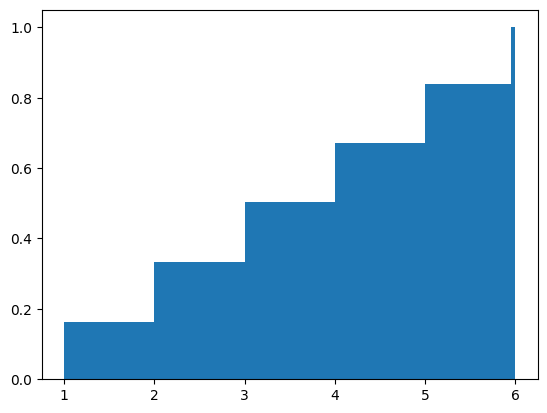

In [9]:
plt.hist(sample, bins=100, density=True, cumulative=True);

## 2. Нормальный закон распределения
В теории статистики доказаны две теоремы, которые обосновывают все статистические вычисления. В силу своей важности эти теоремы получили громкие названия: Центральная предельная теорема и Закон больших чисел.

### 2.1 Закон больших чисел и центральная предельная теорема
*Закон больших чисел* утверждает, что какое бы ни было распределение случайной величины, среднее арифметическое ее реализаций при их большом числе близко к истинному значению среднего значения распределения.

*Центральная предельная теорема* утверждает, что если случайная величина формирует свои значения под действием многочисленных, независимых факторов, влияние каждого из которых пренебрежимо мало, то такая величина распределена нормально.

По ЦПТ получается, что среднее случайных величин будет распределено как $N(\mu, \sigma^2/n)$.

**Задание.**
Напишите функцию, которая будет выдавать ожидаемое нами стандартное отклонение для среднего по k случайным равномерно распределенным от 0 до 1 величинам.

**Подсказка:**
Вообще говоря дисперсия равномерной случайной величины равна $\frac{(b - a)^2}{12}$

In [10]:
def get_std(k: int):
    return np.sqrt((1 / 12) / k)

Давайте посмотрим на теорему в действии. Сформируем случайную величину, которая представляет собой сумму $k$ случайных чисел из какого-нибудь распределения (например, равномерного). Сгенерируем  $N$ таких сумм и посмотрим, как они будут распределены.

In [11]:
N = 10000
k = 10

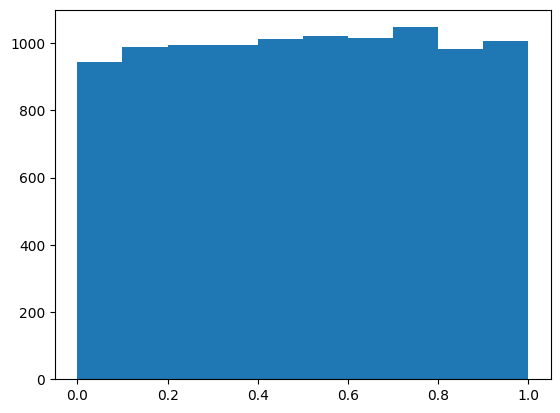

In [12]:
# убедимся, что умеем генерировать массив из N случайных равномерно распределенных на [0; 1] чисел
plt.hist(np.random.random(N));

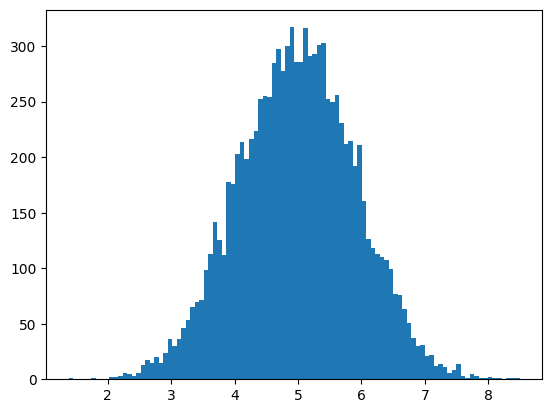

In [13]:
# складываем покоординатно k массивов, получаем массив из N сумм, строим гистограмму
uniform_sum = sum(np.random.random(N) for _ in range(k))
plt.hist(uniform_sum, bins=100);

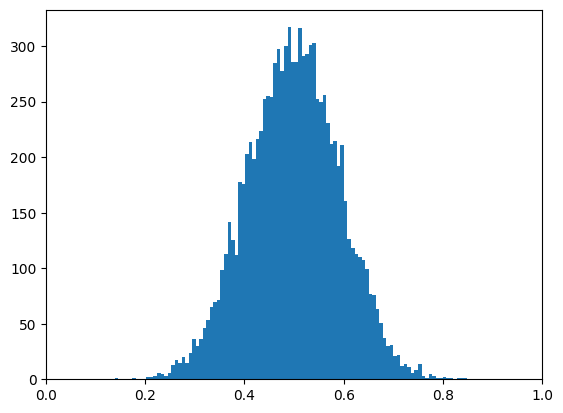

In [14]:
# а теперь давайте посмотрим на то, как распределено среднее по этим величинам
uniform_mean = uniform_sum / k
plt.hist(uniform_mean, bins=100)
plt.xlim([0, 1]);

In [15]:
np.mean(uniform_mean), np.std(uniform_mean), get_std(k)

(0.49878449173946565, 0.09227967028022986, 0.09128709291752768)

In [16]:
k = 100

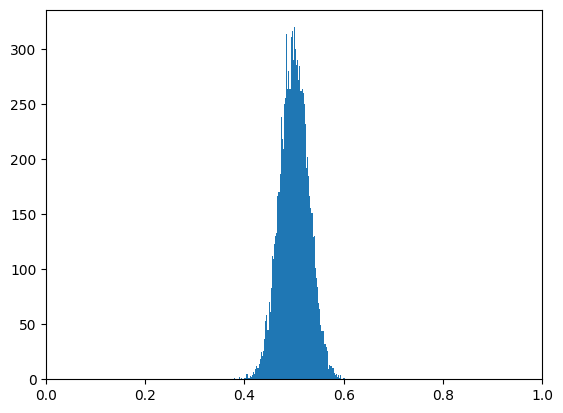

In [17]:
uniform_sum = sum(np.random.random(N) for _ in range(k))
uniform_mean = uniform_sum / k
plt.hist(uniform_mean, bins=100)
plt.xlim([0, 1]);

In [18]:
np.mean(uniform_mean), np.std(uniform_mean), get_std(k)

(0.5001915634347984, 0.02892205738613774, 0.028867513459481287)

In [19]:
k = 1000

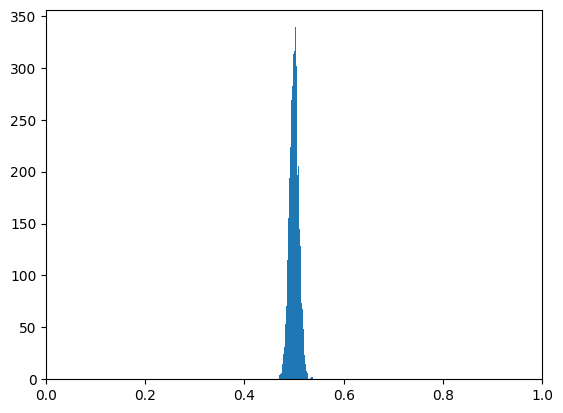

In [20]:
uniform_sum = sum(np.random.random(N) for _ in range(k))
uniform_mean = uniform_sum / k
plt.hist(uniform_mean, bins=100)
plt.xlim([0, 1]);

In [21]:
np.mean(uniform_mean), np.std(uniform_mean), get_std(k)

(0.5000325450941279, 0.009145293518300785, 0.009128709291752768)

Эмпирический результат совпал с теоретическим — ура!

### 2.2 Формулы для функции и плотности нормального распределения
*Теория. Взглянуть мельком.*

Функция нормального распределения:

$$Ф(x)=\frac{1}{\sigma\sqrt{2\pi}}\int\limits_{-\infty}^x\exp\left(-\frac{(t-\mu)^2}{2\sigma^2}\right) dt. $$

Плотность нормального распределения:

 $$  f(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right). $$

### 2.3 Генерирование выборки, графики функций распределения и плотностей, эмпирических и теоретических

In [22]:
mu = 0
sigma = 1
n = 100

# сгенерируем выборку из нормального распределения
sample_normal = np.random.normal(mu, sigma, n)

# 10 первых значений
sample_normal[:10]

array([-0.2976782 , -0.74084866, -1.48889675,  0.37198082, -0.78248553,
       -0.33806695,  0.34136013,  0.07979595, -0.34976769, -1.17465246])

In [23]:
norm_random_variates = sts.norm(mu, sigma)

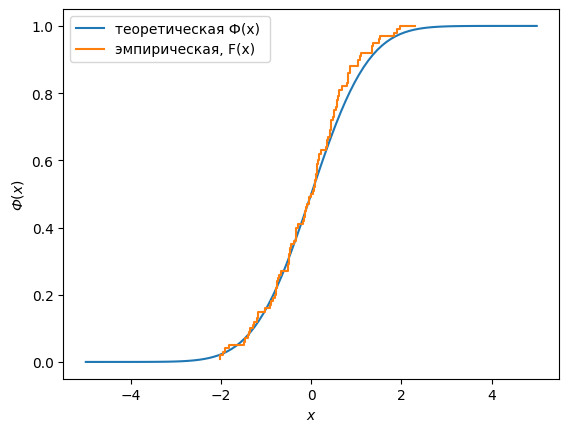

In [24]:
# нарисуем функцию распределения: теоретическую и эмпирическую, составленную по выборке

# теоретическая функция распределения cdf - cumulative density function
x = np.linspace(-5, 5, 100)
cdf = norm_random_variates.cdf(x)
plt.plot(x, cdf, label="теоретическая Ф(x) ")

# 'эмпирическая функция распределения
F = ECDF(sample_normal)
plt.step(F.x, F.y, label="эмпирическая, F(x)")

plt.ylabel("$Ф(x)$")
plt.xlabel("$x$")
plt.legend(loc="upper left");

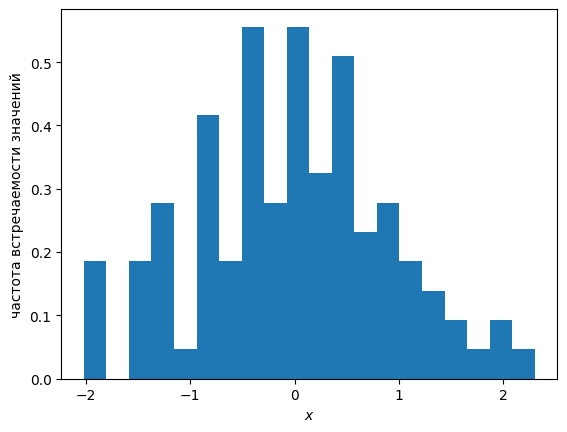

In [25]:
plt.hist(sample_normal, bins=20, density=True)
plt.ylabel("частота встречаемости значений")
plt.xlabel("$x$");

Возьмем n побольше:

In [26]:
n = 100000
sample_normal = np.random.normal(mu, sigma, n)

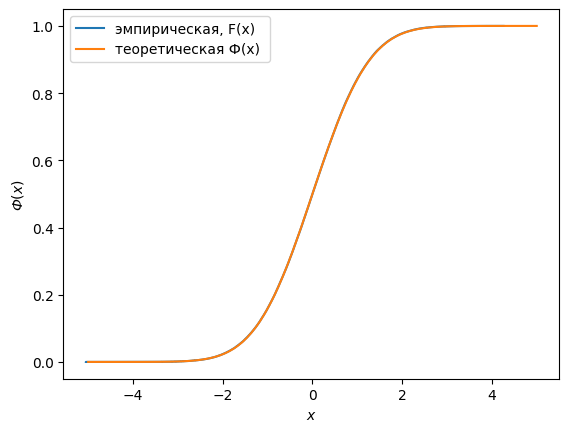

In [27]:
# эмпирическая функция распределения
F = ECDF(sample_normal)
plt.step(F.x, F.y, label="эмпирическая, F(x)")

# теоретическая функция распределения cdf — cumulative density function
x = np.linspace(-5, 5, 100)
cdf = norm_random_variates.cdf(x)
plt.plot(x, cdf, label="теоретическая Ф(x) ")

plt.ylabel("$Ф(x)$")
plt.xlabel("$x$")
plt.legend(loc="upper left");

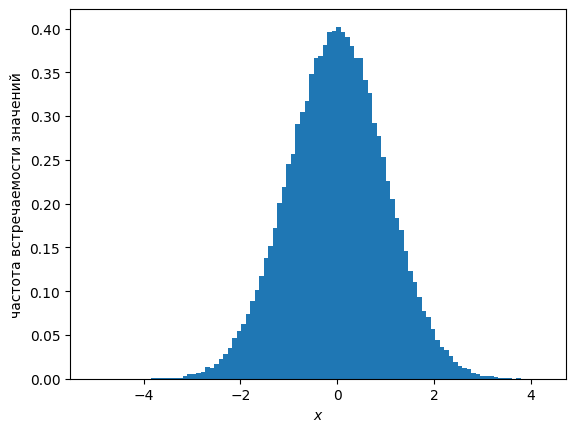

In [28]:
plt.hist(sample_normal, bins=100, density=True)
plt.ylabel("частота встречаемости значений")
plt.xlabel("$x$");

*Плотностью распределения* называется производная от функции распределения: $f(x)=F'(x)$.

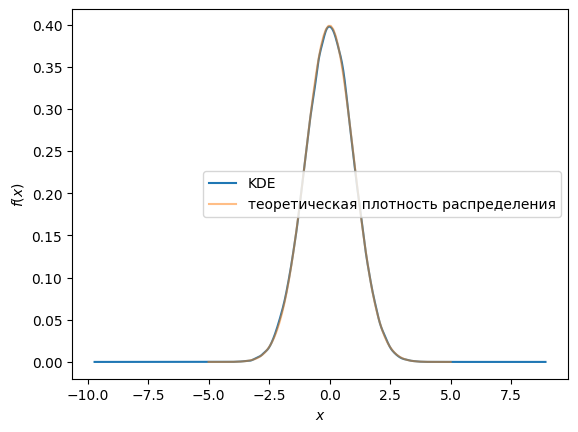

In [29]:
# эмпирическая, построенная по выборке с помощью ядерного сглаживания — KDE, Kernel Density Estimation
df = pd.DataFrame(sample_normal, columns=["KDE"])
ax = df.plot(kind="density")

# теоретическая плотность — pdf, probability density function
x = np.linspace(-5, 5, 100)
pdf = norm_random_variates.pdf(x)
plt.plot(x, pdf, label="теоретическая плотность распределения", alpha=0.5)
plt.legend()
plt.ylabel("$f(x)$")
plt.xlabel("$x$");

## 3. Нахождение доверительных интервалов

### 3.1 Упражнения и теория

Предварительно сделаем несколько упражнений.

*Упр. 1*

Найдем, левее какого числа находится 95% значений нормально распределенной случайной величины с $\mu=0$ и $\sigma=1$, т.е. 95-ый квантиль.

In [30]:
mu = 0
sigma = 1
sts.norm(mu, sigma).ppf(0.95)

1.6448536269514722

*Упр. 2*

Выполним обратную операцию, убедимся, что вероятность принять значения, меньшие чем 1.6448536269514722, равна 95%.


In [31]:
sts.norm(mu, sigma).cdf(1.644853626951472)

0.95

*Упр. 3*

Пользуясь формулой $P(a\le X<b)=F(b)-F(a)$ определим вероятность того, что нормально распределенная случайная величина с $\mu=0$ и $\sigma=1$ примет значения $x \in [2;3]$ 

In [32]:
P = sts.norm(mu, sigma).cdf(3) - sts.norm(mu, sigma).cdf(2)
print(P)

0.021400233916549105


На практике приходится решать и обратную задачу: находить, в каких границах могут находиться с заданной вероятностью ("надежностью") значения случайной величины.

**Доверительным** называют интервал, который покрывает неизвестный параметр с заданной надёжностью. В дальнейшем нам нужно будет находить доверительный интервал для математического ожидания нормально распределенной случайной величины с надежностью $\gamma$.

**Теория.**


В теории при небольших объемах данных такой интервал можно найти из формулы:
$${P}\left( {\bar X}-t_{\frac{1+\gamma}{2},n-1}\cdot \frac{S}{\sqrt{n}}\le \mu\le {\bar X}+t_{\frac{1+\gamma}{2},n-1}\cdot \frac{S}{\sqrt{n}}\right)=\gamma, $$
где $t_{\alpha,n-1}$ — $\alpha$-квантили распределения Стьюдента, т.е. распределения случайой величины $T=\frac{{\bar X}-\mu}{S\,/\,\sqrt{n}}$, а $S$ — несмещённое выборочное стандартное отклонение.

При больших объемах и/или известном стандартном отклонении математического ожидания вместо распределения Стьюдента используется нормальное распределение, и

$${P}\left( {\bar X}-z_{\frac{1+\gamma}{2}}\cdot \frac{\sigma}{\sqrt{n}}\le \mu\le {\bar X}+z_{\frac{1+\gamma}{2}}\cdot \frac{\sigma}{\sqrt{n}}\right)=\gamma, $$
где $z_{\alpha}$ — $\alpha$-квантили стандартного нормального распределения, т.е. распределения случайной величины $Z=\frac{{\bar X}-\mu}{\sigma\,/\,\sqrt{n}}$, а $S$ — известное стандартное отклонение.

Возьмем выборку из распределения бернулли:

In [33]:
random_ber = np.random.randint(2, size=50)

In [34]:
random_ber

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1])

### 3.2 Доверительный интервал на основе нормального распределения

$$\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}$$

In [35]:
from statsmodels.stats.proportion import proportion_confint

In [36]:
def normal_int(random_ber: np.array):
    s = random_ber.sum()
    n = len(random_ber)

    normal_interval = proportion_confint(s, n, method="normal", alpha=0.05)
    return np.array(normal_interval)


def normal_int_custom(random_ber: np.array):
    s = random_ber.sum()
    n = len(random_ber)
    z_alpha = 1.959964

    p_hat = s / n
    half_int = z_alpha * np.sqrt(p_hat * (1 - p_hat) / n)
    return np.array([p_hat - half_int, p_hat + half_int])

In [37]:
assert np.allclose(normal_int(random_ber), normal_int_custom(random_ber))

In [38]:
for size in [10, 100, 1000, 10000]:
    random_ber = np.random.randint(2, size=size)
    print(normal_int(random_ber))

[0.19010248 0.80989752]
[0.31360244 0.50639756]
[0.4640118 0.5259882]
[0.48790028 0.50749972]


### 3.3 Доверительный интервал Уилсона (лучше, для средних значений близких к 0 и 1)

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [39]:
p = 0.9
random_ber = np.random.choice(2, size=1000, p=[1.0 - p, p])

In [40]:
def wilson_int(random_ber):
    s = random_ber.sum()
    n = len(random_ber)

    normal_interval = proportion_confint(s, n, method="wilson", alpha=0.05)
    return np.array(normal_interval)


def wilson_int_custom(random_ber):
    s = random_ber.sum()
    n = len(random_ber)
    z_alpha = 1.959964

    p_hat = s / n  # your code here

    half_int = z_alpha * np.sqrt(p_hat * (1 - p_hat) / n + z_alpha / (4 * n * n))

    return (
        1
        / (1 + z_alpha * z_alpha / n)
        * np.array(
            [
                p_hat + z_alpha**2 / (2 * n) - half_int,
                p_hat + z_alpha**2 / (2 * n) + half_int,
            ]
        )
    )

In [41]:
print(wilson_int(random_ber))
print(wilson_int_custom(random_ber))

[0.8820053  0.91891799]
[0.88205394 0.91886935]


In [42]:
assert np.allclose(wilson_int(random_ber), wilson_int_custom(random_ber), atol=1e-4)

In [43]:
p = 0.9

for size in [10, 100, 1000, 10000]:
    random_ber = np.random.choice(2, size=size, p=[1.0 - p, p])
    print(wilson_int(random_ber), normal_int(random_ber))

[0.59584997 0.98212379] [0.71406149 1.        ]
[0.75579731 0.89904712] [0.76814653 0.91185347]
[0.86587845 0.90515964] [0.86737774 0.90662226]
[0.88935167 0.90134459] [0.88950431 0.90149569]


[Прикольная визуализация](https://rpsychologist.com/d3/ci/), если еще хочется посмотреть на то, что такое доверительный интервал.

## 4. Проверка гипотез

P-value
![title](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/P-value_in_statistical_significance_testing.svg/474px-P-value_in_statistical_significance_testing.svg.png)

### 4.1 Критерии Стьюдента (T-тест)

Работает для тех значений, которые распределены нормально

Нужно проверить на нормальность:
- q-q plot
- Критерий Шапиро-Уилка: (гипотеза о нормальности распределения)

In [44]:
test_norm = np.random.normal(size=5000)
test_exp = np.random.exponential(size=5000)

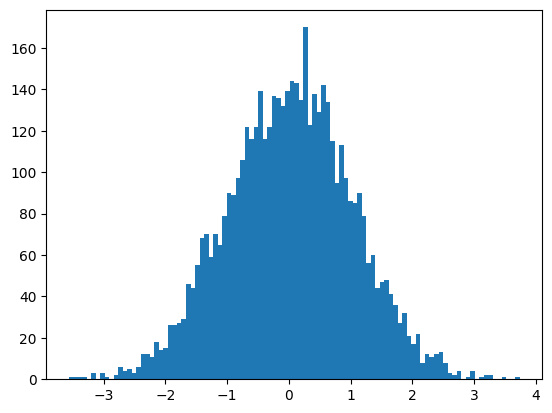

In [45]:
plt.hist(test_norm, bins=100);

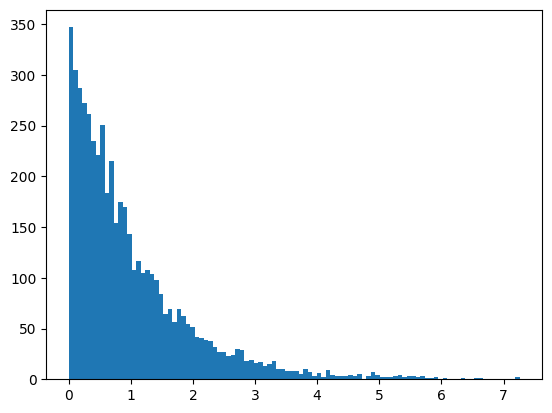

In [46]:
plt.hist(test_exp, bins=100);

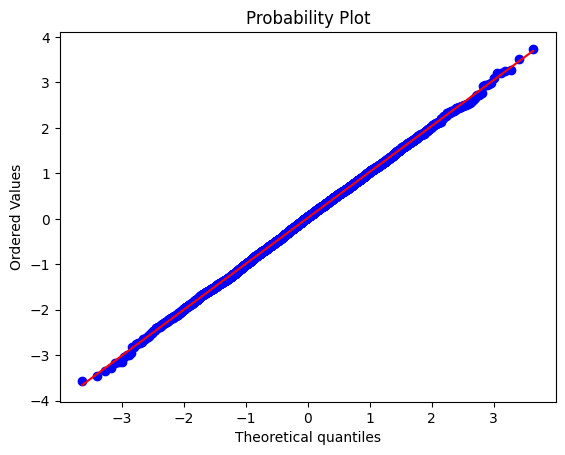

In [47]:
stats.probplot(test_norm, dist="norm", plot=pylab);

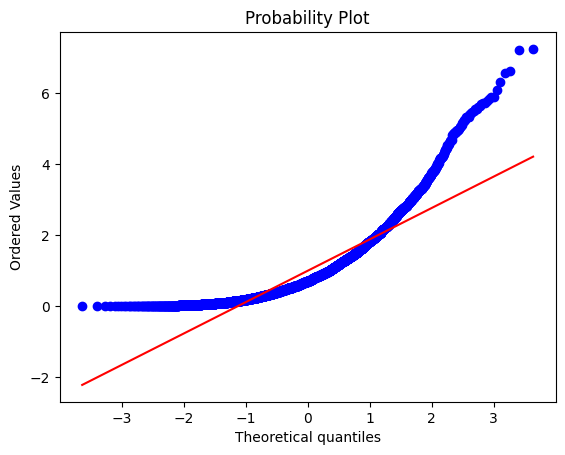

In [48]:
stats.probplot(test_exp, dist="norm", plot=pylab);

In [49]:
print(
    f"Shapiro-Wilk normality test, W-statistic: %f, p-value: %f"
    % stats.shapiro(test_norm)
)

Shapiro-Wilk normality test, W-statistic: 0.999734, p-value: 0.804801


In [50]:
print(
    f"Shapiro-Wilk normality test, W-statistic: %f, p-value: %f"
    % stats.shapiro(test_exp)
)

Shapiro-Wilk normality test, W-statistic: 0.821864, p-value: 0.000000


#### 4.2 Одновыборочный критерий Стьюдента

$H_0\colon$ среднее значение некоторой выборки равняется заданному числу $m$,

$H_1\colon$ не равно.

Критерий:

$$t = \frac{\bar{X} - m}{s/\sqrt{n}}$$ 

$$s^2 = \frac{1}{n-1}\sum_{i}^{n} (X_i - \bar{X})^2,$$

где $\bar{X}$ — среднее значение случайной величины $X$; $s$ — несмещенная оценка дисперсии; $n$ — размер выборки. При нулевой гипотезе эта статистика имеет распределение Стьюдента с $(n-1)$ степенями свободы.

Для полученного значения критерия вычисляем p-value $p$:
- Если $p < \alpha$, то гипотеза $H_0$ отвергается в пользу $H_1$
- Если $p \ge \alpha$, то принимается гипотеза $H_0$

Обычно пороговое значение $\alpha=0.05$.

In [51]:
stats.ttest_1samp(test_norm, 0.02)

TtestResult(statistic=0.09943459523937705, pvalue=0.9207972028614158, df=4999)

In [52]:
print("95%% confidence interval: [%f, %f]" % zconfint(test_norm))

95% confidence interval: [-0.006602, 0.049446]


In [53]:
stats.ttest_1samp(test_norm, 0.05)

TtestResult(statistic=-1.9987101053219793, pvalue=0.0456937845767527, df=4999)

#### 4.1.2 Двувыборочный критерий Стьюдента

$H_0\colon$ средние значения двух выборок одинаковы

$H_1\colon$ не одинаковы.

Рассмотрим разность средних значений двух выборок $\bar{X}_1$ и $\bar{X}_2$:

$$\Delta = \bar{X}_1 - \bar{X}_2$$

Дисперсия разности равна:

$$s^2_{\Delta} = \frac{s_1^{2}}{n_1} + \frac{s_2^{2}}{n_2}$$ 

где

$$s^2 = \frac{1}{n-1}\sum_{i}^{n} (X_i - \bar{X})^2$$ 


Двувыборочный критерий Стьюдента:

$$t = \frac{\Delta}{s_{\Delta}},$$

где $\bar{X}$ — среднее значение случайной величины $X$; $s$ — несмещенная оценка дисперсии; $n$ — размер выборки. При нулевой гипотезе и $s_1 = s_2$ эта статистика имеет распределение Стьюдента с $(n_1 + n_2 - 2)$ степенями свободы.

Для полученного значения критерия вычисляем p-value $p$:
- Если $p < \alpha$, то гипотеза $H_0$ отвергается в пользу $H_1$
- Если $p \ge \alpha$, то принимается гипотеза $H_0$

Обычно пороговое значение $\alpha=0.05$.

In [54]:
test_a = np.random.normal(loc=0.05, size=10000)
test_b = np.random.normal(loc=0.0, size=10000)

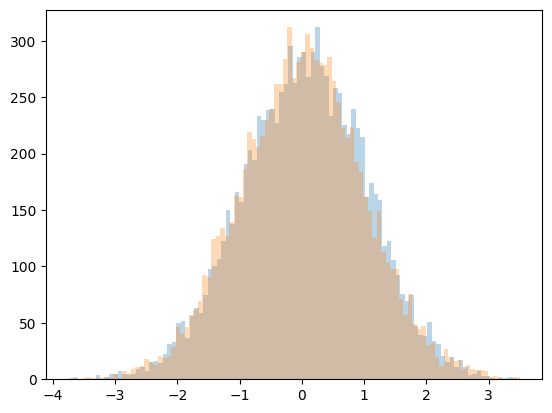

In [55]:
plt.hist(test_a, bins=100, alpha=0.3)
plt.hist(test_b, bins=100, alpha=0.3)
plt.show()

In [56]:
print("95%% confidence interval for a: [%f, %f]" % zconfint(test_a))
print("95%% confidence interval for b: [%f, %f]" % zconfint(test_b))

95% confidence interval for a: [0.027390, 0.066465]
95% confidence interval for b: [-0.013078, 0.025950]


In [57]:
scipy.stats.ttest_ind(test_a, test_b, equal_var=False)

Ttest_indResult(statistic=2.8739992858343615, pvalue=0.00405736942176802)

#### 4.1.2 Двувыборочный критерий Стьюдента для зависимых выборок
$H_0\colon$ средние значения двух выборок одинаковы

$H_1\colon$ не одинаковы.

Критерий:

$$t = \frac{M_d}{s_d/\sqrt{n}},$$

где $M_d$ — среднее значение случайной величины $d = X_1 - X_2$; $s_d$ — несмещенная оценка дисперсии это случайной величины; $n$ — размер выборки. При нулевой гипотезе эта статистика имеет распределение Стьюдента с $(n-1)$ степенями свободы.

Для полученного значения критерия вычисляем p-value $p$:
- Если $p < \alpha$, то гипотеза $H_0$ отвергается в пользу $H_1$
- Если $p \ge \alpha$, то принимается гипотеза $H_0$

Обычно пороговое значение $\alpha=0.05$.

In [58]:
SIZE = 1000

In [59]:
test_ab = np.random.normal(size=SIZE)
test_a = test_ab + np.random.normal(loc=0.4, size=SIZE)
test_b = test_ab + np.random.normal(loc=0.5, size=SIZE)

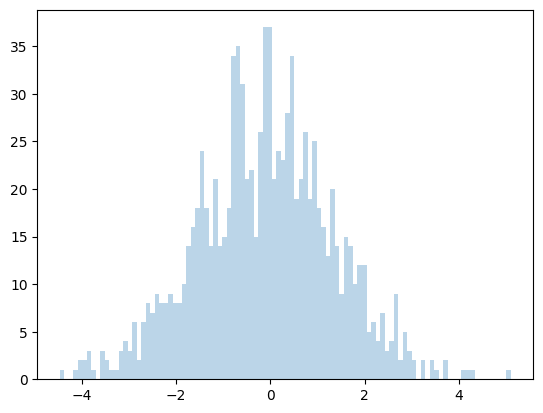

In [60]:
mean_list = test_a - test_b
plt.hist(mean_list, bins=100, alpha=0.3)
plt.show()

In [61]:
scipy.stats.ttest_ind(test_a, test_b, equal_var=False)

Ttest_indResult(statistic=-1.7167271983339023, pvalue=0.08618401792352338)

In [62]:
stats.ttest_rel(test_a, test_b)

TtestResult(statistic=-2.4772986742338077, pvalue=0.013402611072617143, df=999)

In [63]:
print("95%% confidence interval: [%f, %f]" % DescrStatsW(mean_list).tconfint_mean())

95% confidence interval: [-0.202456, -0.023483]


### 4.2 Непараметрические криетрии

Используются, если выборки распределены ненормально

### 4.2.1 Двувыборочный непараметрический критерий для независимых выборок
$H_0\colon$ средние значения двух выборок одинаковы

$H_1\colon$  не одинаковы.

### 4.2.2 Ранговый критерий Манна-Уитни

- Собираем наблюдения в одну выборку с $n = n_1 + n_2$ наблюдениями.
- Ранжируем наблюдения. Считаем сумму рангов отдельно для каждой группы: $R_x$ и $R_y$.
- Считаем статистики:

$$U_x = R_x - \frac{n_1(n_1+1)}{2}$$
$$U_y = R_y - \frac{n_2(n_2+1)}{2}$$
$$U = \min(U_x, U_y)$$

- Для полученного значения критерия вычисляем p-value $p$:
    - Если $p < \alpha$, то гипотеза $H_0$ отвергается в пользу $H_1$
    - Если $p \ge \alpha$, то принимается гипотеза $H_0$

Обычно пороговое значение $\alpha=0.05$.

In [64]:
np.random.seed(42)
N = 10

test_a = np.random.beta(2.0, 2.0, size=N)
test_b = np.random.beta(2.0, 3.0, size=N)

In [65]:
test_a.mean(), test_b.mean()

(0.5472312733236799, 0.36687490750463303)

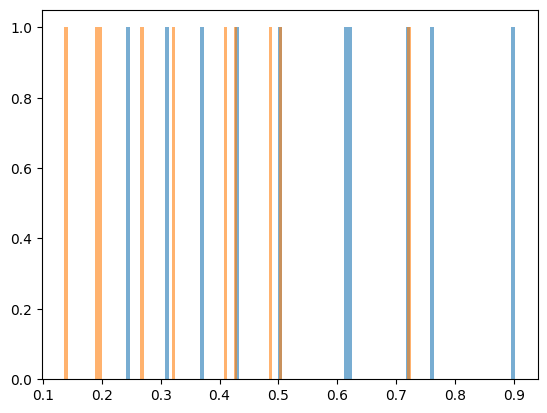

In [66]:
plt.hist(test_a, bins=100, alpha=0.6)
plt.hist(test_b, bins=100, alpha=0.6)
plt.show()

In [67]:
scipy.stats.ttest_ind(test_a, test_b, equal_var=False)

Ttest_indResult(statistic=2.0495584680258787, pvalue=0.055675834335877854)

In [68]:
stats.mannwhitneyu(test_a, test_b)

MannwhitneyuResult(statistic=74.0, pvalue=0.07566157214388704)

In [69]:
print("95%% confidence interval for the mean test_a: [%f, %f]" % zconfint(test_a))
print("95%% confidence interval for the mean test_b: [%f, %f]" % zconfint(test_b))

95% confidence interval for the mean test_a: [0.415666, 0.678797]
95% confidence interval for the mean test_b: [0.255353, 0.478397]


## 5. A/B тестирование

A/B-тестирование (англ. A/B testing, Split testing) — метод маркетингового исследования, суть которого заключается в том, что контрольная группа элементов сравнивается с набором тестовых групп, в которых один или несколько показателей были изменены, для того, чтобы выяснить, какие из изменений улучшают целевой показатель и улучшают ли.

Типичное применение в веб-дизайне — исследование влияния цветовой схемы, расположения и размера элементов интерфейса на конверсию сайта.

Конверсия (Conversion Rate) в интернет-маркетинге — это отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия (покупку, регистрацию, подписку, посещение определённой страницы сайта, переход по рекламной ссылке), к общему числу посетителей сайта, выраженное в процентах. 



В теории принципы A/B тестирования невероятно просты:

- Выдвигаем предположение о том, что какое-то изменение (например, персонализация главной страницы) увеличит конверсию интернет-магазина.

- Создаем альтернативную версию сайта «Б» — копию исходной версии «А» с изменениями, от которых мы ждем роста эффективности сайта.

- Всех посетителей сайта случайным образом делим на две равные группы: одной группе показываем исходный вариант (контрольная группа) , второй группе (тестовой) — альтернативный. Одновременно измеряем конверсию для обеих версий сайта.

- Определяем статистически достоверно победивший вариант.

Мы будем анализировать результаты A/B тестирования двух версий дизайна кнопки сайта интернет-магазина. 

Целевым действием считаем клик по этой кнопке. 

Первые три этапа А/В тестирования за нас провели, результаты предоставили в виде файла ab_dataset.csv. Нам осталось выполнить четвертый пункт.

 <a id='eda'></a>
### Первичный анализ данных

Прочитаем данные из файла `ab_dataset.csv`. Сохраним их в датафрейм `df`. 

Прочитаем данные и посмотрим на первые 5 строк:

In [70]:
# !wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2021/seminars/sem10_stat/ab_data.csv

In [71]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Посмотрим, сколько посетителей заходио на сайт (количество строк в нашем датафрейме)

In [72]:
# количество посетителей всего
n_rows = df.shape[0]
print("Число строк: {}".format(n_rows))

Число строк: 294478


Сколько уникальных пользователей (уникальных `user_id`) в датасете?

In [73]:
user_total = df.nunique()["user_id"]
print("Число уникальных пользователей : {}".format(user_total))

Число уникальных пользователей : 290584


Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [74]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print(
    "Из тестовой группы неверно направлены {}".format(len(mismatch_1))
    + " пользователей"
)

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print(
    "Из контрольной группы неверно направлены  {}".format(len(mismatch_2))
    + " пользователей"
)

Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


Выясним, есть ли в данных пропуски.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Из сообщений следует, что пропущенных значений нет.

Конверсия по всем посетителям

In [76]:
p_all = df["converted"].mean()
print("Конверсия по всем посетителям: {} %".format(p_all * 100))

Конверсия по всем посетителям: 11.96591935560551 %


In [77]:
# можно и так:
sum(df["converted"].values) / n_rows

0.11965919355605512

Давайте посмотрим на описательную статистику нашего датасета (воспользуемся функцией  `describe`) и постараемся получить ответы на следующие вопросы:

- Какова вероятность клика для посетителей из контрольной группы (старый дизайн)?

- Какова вероятность клика для посетителей из тестовой группы (новый дизайн кнопки)?

- Каково соотношение размеров тестовой и контрольный групп? Какова вероятность, что очередной посетитель будет направлен на версию со старым дизайном? С новым дизайном?

In [78]:
df_grp = df.groupby("group")
df_grp.describe()

user_id                                                    
              count           mean           std       min       25%   
group                                                                  
control    147202.0  788123.098035  91278.896888  630002.0  709287.0  \
treatment  147276.0  787825.226283  91142.800641  630000.0  708729.5   

                                         converted                            
                50%        75%       max     count      mean       std  min   
group                                                                         
control    788053.5  867155.50  945998.0  147202.0  0.120399  0.325429  0.0  \
treatment  787837.5  866693.75  945999.0  147276.0  0.118920  0.323695  0.0   

                               
           25%  50%  75%  max  
group                          
control    0.0  0.0  0.0  1.0  
treatment  0.0  0.0  0.0  1.0

Ответы на остальные вопросы можно найти, например, так:

In [79]:
# объем тестовой группы
n_rows_treat = len(df[df["group"] == "treatment"])

# объем контрольной группы
n_rows_contr = n_rows - n_rows_treat

print(
    "Соотношение размеров тестовой и контрольной групп: {}".format(
        n_rows_treat / n_rows_contr
    )
)

print(
    "Вероятность, что новый пользователь будет направлен на версию со старым дизайном: {}".format(
        n_rows_treat / n_rows
    )
)
print(
    "Вероятность, что новый пользователь будет направлен на версию с новым дизайном: {}".format(
        n_rows_contr / n_rows
    )
)

Соотношение размеров тестовой и контрольной групп: 1.0005027105609978
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: 0.5001256460584492
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: 0.49987435394155083


**Задание **

А теперь ответьте на главный вопрос данного этапа:  выявил ли предварительный анализ, что дизайн кнопки влияет на конверсию и если да, то как именно?

<a id='si'></a>
### Статистический вывод для A/B Теста

По нашим данным очевидно, что кликабельность старой версии выше, чем новой, и напрашивается решение оставить всё как есть.  Однако бизнес потребует обоснований для такого глобального решения, бОльших, чем "очевидно по результатам одного эксперимента". 

И такие обоснования предоставляет специально разработанная методология - статистический вывод. 

Статистический вывод - это переход от данных о статистической выборке (нашего датасета) к обобщениям в виде параметров генеральной совокупности с вычислением степени уверенности в справедливости этих обобщений.

Будем считать, что клик — это некоторая случайная переменная , принимающая значения 1  или 0 с вероятностями $\theta$ и $1-\theta$ соответственно. 

Применительно к нашей задаче посетитель может кликнуть на кнопку (с вероятностью $\theta$) или не кликнуть на нее (с вероятностью, соответственно,  $1-\theta$)

На практике статистические заключения опираются на допущения о том, как распределены рассматриваемые случайные переменные (данные). (Даже принято преобразовывать данные с тем, чтобы они соответствовали одному из известных распределений)

Распределение вероятностей — это выражение, которое определяет, какие значения будет принимать данная переменная или параметр,  и как часто будет встречаться каждое из этих значений.

 Наша случайная переменная — клик — имеет распределение, которое называется распределением Бернулли с параметром $\theta$:
$$ p(k) = \theta^k (1 - \theta)^{1 - k}, $$

где $p(k)$ —  вероятность случайной переменной  принять значение $k$, $k \in \{ 0;1\}$.

Из теории известно, что среднее значение распределения Бернулли равно $\mu = \theta$, а дисперсия равна $\sigma^2 = \theta(1 - \theta)$. Нас интересует конверсия сайта, в рассматриваемой постановке она равна $\theta$.

<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза в нашем случае может быть сформулирована, например, так: "Конверсия сайта со старым дизайном не меньше, чем с новым"

<a id='si2'></a>
#### Формальное описание нулевой и альтернативной гипотез

$H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

$H_{1}$ : $\theta_{new}$ > $\theta_{old}$ 

<a id='si1'></a>
#### Выбор подходящего статистического теста (статистического критерия)

Истинные значения $\theta_{new}$ и $\theta_{old}$ мы найти не можем, но мы можем их сравнить. В этом помогут те самые две теоремы.






На основании Закона больших чисел мы можем оценить средние значения случайных величин $\theta_{new}$ и $\theta_{old}$ на  генеральных совокупностях по их средним значениям на наших больших выборках.

На основании Центральной предельной теоремы средние значения распределены нормально при больших объемах выборок.

Чтобы выбрать для проверки наших гипотез подходящий статистический критерий, уясним задачу. Нам нужно выяснить, случайно или значимо отличаются средние значения, т.е. доли, кликнувших посетителей в контрольной и тестовой выборках.

<a id='si4'></a>
#### Проведение вычислений. $Z$-критерий.

$$Z = \frac{p_1 - p_2}{\sqrt{p(1-p) (\frac{1}{n_1} + \frac{1}{n_2})}}$$

где $p_1$ - конверсия в первой группе; $p_2$ - конверсия во второй группе; $p$ - конверсия во всех наблюдениях; $n_1$, $n_2$ - количество наблюдений в группах.

Для полученного значения критерия вычисляем p-value $p$. 
- Если $p < \alpha$, то гипотеза $H_0$ отвергается в пользу $H_1$.
- Если $p \ge \alpha$, то принимается гипотеза $H_0$.

Обычно пороговое значение $\alpha=0.05$.

In [80]:
import statsmodels
import statsmodels.api as sm

convert_contr = sum(df.query("group == 'control'")["converted"])
convert_treat = sum(df.query("group == 'treatment'")["converted"])

z_score, p_value = sm.stats.proportions_ztest(
    [convert_treat, convert_contr], [n_rows_treat, n_rows_contr], alternative="larger"
)
print("Z-статистика={},  p_value={}".format(z_score, p_value))

Z-статистика=-1.2369217547321678,  p_value=0.8919419336512124


#### Проведение вычислений. $T$-test.

In [81]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(
    df.query("group == 'treatment'")["converted"],
    df.query("group == 'control'")["converted"],
    alternative="larger",
    usevar="unequal",
)

In [82]:
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=-1.236919107065067,  p_value=0.8919409489056522


#### Проведение вычислений. $Mann–Whitney$-test.

In [83]:
w_score, p_value = sts.mannwhitneyu(
    df.query("group == 'treatment'")["converted"],
    df.query("group == 'control'")["converted"],
    alternative="greater",
)

In [84]:
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=10823622516.0,  p_value=0.8919415509213815


<a id='m12'></a>
### Ошибки первого и второго рода

|  | | | |
|----------|:---------|:--------|:---------|
|  | | 	Верная гипотеза: | |
|  |     | $H_0$   | $H_1$    |
| Результат применения критерия: | $H_0$   |$H_0$ верно принята  |$H_0$ неверно принята (ошибка II рода)  |  
|  |$H_1$   |$H_0$ неверно отвергнута(ошибка I рода)  | $H_0$ верно отвергнута   |



Уровень значимости (статистическая значимость, statistical significance) $\alpha$ - это и есть вероятность ошибки первого рода, т. е. вероятность принятия альтернативной гипотезы при условии, что на самом деле верна нулевая гипотеза. 

Обозначим  $\beta$  вероятность ошибки второго рода. 

Величина  $1-\beta$ называется *статистической мощностью* (statistical power) критерия. По сути мощность показывает, сколько значений, соответствующих альтернативной гипотезе, мы действительно отнесем к альтернативной гипотезе

![asd](https://habrastorage.org/files/475/9e5/ebc/4759e5ebcfc54b11a852704017d2d8ac.png)

![mem](https://i2.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg?fit=960%2C720&ssl=1)